In [2]:
import networkx as nx

In [35]:
import random
import numpy as np
import matplotlib.pyplot as plt
from gym.spaces import Tuple, Discrete, Box

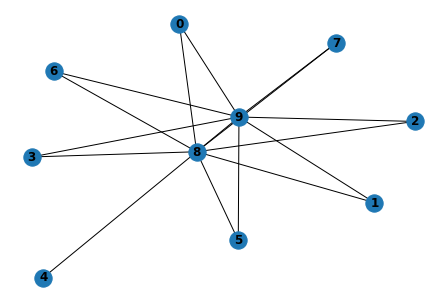

In [21]:
graph = nx.barabasi_albert_graph(10,8,68)
nx.draw(graph, with_labels=True, font_weight='bold')

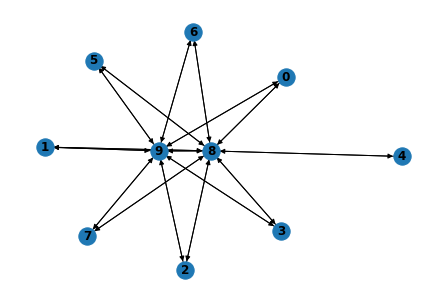

In [24]:
DG = nx.to_directed(graph)
nx.draw(DG, with_labels=True, font_weight='bold')

In [27]:
list(graph.neighbors(8))

[0, 1, 2, 3, 4, 5, 6, 7, 9]

In [34]:
graph.nodes()
len(graph.nodes())

10

In [50]:
Box(low=0.0, high=1.0, shape=(len(DG.nodes()) + len(DG.edges()),), dtype=np.float16)

Box(42,)

In [51]:
DG.nodes()


NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

In [52]:
DG.edges()

OutEdgeView([(0, 8), (0, 9), (1, 8), (1, 9), (2, 8), (2, 9), (3, 8), (3, 9), (4, 8), (5, 8), (5, 9), (6, 8), (6, 9), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 5), (9, 6), (9, 7), (9, 8)])

In [53]:

import argparse
from networkx import nx
import gym
import numpy as np
from gym import spaces

class Network(gym.Env):

    def __init__(self, configuration: dict, graph: nx.Graph):

        super(Network, self).__init__()
        actionspace = [len(graph.nodes()) for _ in range(len(graph.nodes()))]
        obsspace = [128 for _ in range(len(graph.nodes()))]
        print(actionspace)
        print(obsspace)
        self.action_space = spaces.MultiDiscrete(actionspace)
        self.observation_space = spaces.MultiDiscrete(obsspace)
        print(self.action_space)
        print(self.observation_space)


        self.arrival_time = config['arrival_time']
        self.maxsteps = config['maxsteps']
        # self.packet_size =config['packet_size']
        self.graph = graph
        self.current_timestep = 0
        self.sink,self.source = None,None

        #number of packets at each node
        self.packet_count_per_node=[0 for _ in range(len(self.graph.nodes()))]
        self.sending = [0 for _ in range(len(self.graph.nodes()))]

        #extract the sink and the source node from the graph
        for node,data in self.graph.nodes.data():
            if data['sink']: self.sink=node
            if data['source']: self.source=node
        if self.sink is None or self.source is None:
            print('no sink or no source defined')
            return

    def step(self, action):
        """the action is a list of -num_Nodes- length. action[i]=j means that a packet 
        is sent from node i to node j if possible"""

        reward = 0
        for i,j in enumerate(action):
            #transmitting packets with respect to the actions
            reward  -= self.transmit(i,j)

        #update the nodes according to the packets that has been sent
        for i in range(len(self.packet_count_per_node)):
            self.packet_count_per_node[i] += self.sending[i]
            if self.packet_count_per_node[i] >=128:
                print('dropping packet')
                self.packet_count_per_node[i]=127
                reward -=999999999
        self.sending = [0 for _ in range(len(self.graph.nodes()))]

        #handle packets that were routet successfully to the sink
        reward += self.packet_count_per_node[self.sink]*len(self.graph.nodes())
        self.packet_count_per_node[self.sink]=0

        self.current_timestep+=1
        if(self.current_timestep % self.arrival_time==0):
            #new packet arrives at source node
            self.packet_count_per_node[self.source]+=1

        info=dict()
        state = self.packet_count_per_node
        done = False
        if self.current_timestep >= self.maxsteps: done=True

        return np.array(state), reward, done, info

    def transmit(self,i,j):
        """transmit all packets from node i to node j
        returns the number of packets that were tried to sent"""

        #number of packets that will be tried to sent
        count = self.packet_count_per_node[i]

        #send packets if possible
        if (i,j) in self.graph.edges():
            self.sending[j] += self.packet_count_per_node[i]
            self.packet_count_per_node[i] = 0

        return count

    def reset(self):

        self.packet_count_per_node = [0 for _ in range(len(self.graph.nodes()))]
        self.sending = [0 for _ in range(len(self.graph.nodes()))]

        #the first packet already arrived at the source
        self.packet_count_per_node[self.source]=1
        return np.array(self.packet_count_per_node)

    def render(self, mode='human', close=False):
        pass

In [55]:
    config = {}
    config['maxsteps'] = 200000
    config['arrival_time'] = 2
    config['packet_size'] = 4.0

    G = nx.Graph()
    G.add_node(1, sink=False, source=False)
    G.add_node(2, sink=False, source=False)
    G.add_node(3, sink=False, source=False)
    G.add_node(0, sink=False, source=True)
    G.add_node(4, sink=True, source=False)
    G.add_edges_from([(0,1),(1,2),(1,3),(2,4)])
    # execute flowsim experiment
    network = Network(config,graph=G)

    print(network.reset())
    print(network.step([1, 2, 4, 0, 0]))
    print(network.step([1, 2, 4, 0, 0]))
    print(network.step([1, 2, 4, 0, 0]))
    print(network.step([1, 2, 4, 0, 0]))
    print(network.step([1, 2, 4, 0, 0]))
    network.step([3, 3, 5, 0, 0])

    env = Network(config,graph=G)


[5, 5, 5, 5, 5]
[128, 128, 128, 128, 128]
MultiDiscrete([5 5 5 5 5])
MultiDiscrete([128 128 128 128 128])
[1 0 0 0 0]
(array([0, 1, 0, 0, 0]), -1, False, {})
(array([1, 0, 1, 0, 0]), -1, False, {})
(array([0, 1, 0, 0, 0]), 3, False, {})
(array([1, 0, 1, 0, 0]), -1, False, {})
(array([0, 1, 0, 0, 0]), 3, False, {})
[5, 5, 5, 5, 5]
[128, 128, 128, 128, 128]
MultiDiscrete([5 5 5 5 5])
MultiDiscrete([128 128 128 128 128])
